In [5]:
pip install lifelines

  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'autograd-gamma' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'autograd-gamma'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=a1b1d25fb65620ffc112dd38f2ee98c783d78ebd9d817001e0eb671490d604c1
  Stored in directory: /Users/yashashreeshinde/Library/Caches/pip/wheels/7e/16/46/9477f188924292d3bf1fb8fb42844201591abfc19b7ba6d868
Successfully built autograd-gamma
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [lifelines]/5 [lifelines]
Note: you may need to restart the kernel to use updated packages.


Survival Analysis: Time to Loan Default
Total loans: 255,347
Defaults (events): 29,653
Censored (paid off): 225,694

Loan Term Distribution:
duration
12    50957
24    51009
36    51061
48    51166
60    51154
Name: count, dtype: int64


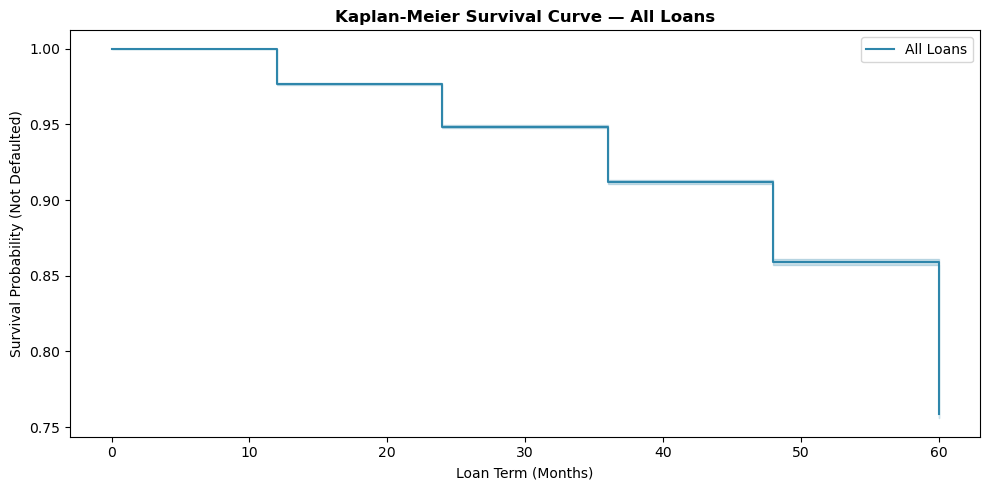


Median survival time: inf

Survival probabilities at key terms:
  Month 12: 0.9768 (97.68% not defaulted)
  Month 24: 0.9485 (94.85% not defaulted)
  Month 36: 0.9120 (91.20% not defaulted)
  Month 48: 0.8592 (85.92% not defaulted)
  Month 60: 0.7587 (75.87% not defaulted)


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
import warnings
warnings.filterwarnings('ignore')


# Load data
df = pd.read_csv('../data/processed/loan_default_cleaned.csv')

# ---- CREATE SURVIVAL DATA ----
# Duration = LoanTerm (how long the loan runs)
# Event = Default (1 = defaulted, 0 = survived/paid)
df['duration'] = df['LoanTerm']
df['event'] = df['Default']

print("Survival Analysis: Time to Loan Default")
print("="*50)
print(f"Total loans: {len(df):,}")
print(f"Defaults (events): {df['event'].sum():,}")
print(f"Censored (paid off): {(df['event']==0).sum():,}")
print(f"\nLoan Term Distribution:")
print(df['duration'].value_counts().sort_index())

# ---- KAPLAN MEIER — OVERALL ----
kmf = KaplanMeierFitter()
kmf.fit(df['duration'], event_observed=df['event'], label='All Loans')

plt.figure(figsize=(10, 5))
kmf.plot_survival_function(ci_show=True, color='#2E86AB')
plt.title('Kaplan-Meier Survival Curve — All Loans', fontweight='bold')
plt.xlabel('Loan Term (Months)')
plt.ylabel('Survival Probability (Not Defaulted)')
plt.tight_layout()
plt.savefig('../visuals/07_km_overall.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nMedian survival time:", kmf.median_survival_time_)
print("\nSurvival probabilities at key terms:")
for t in [12, 24, 36, 48, 60]:
    prob = kmf.survival_function_at_times(t).values[0]
    print(f"  Month {t}: {prob:.4f} ({prob*100:.2f}% not defaulted)")

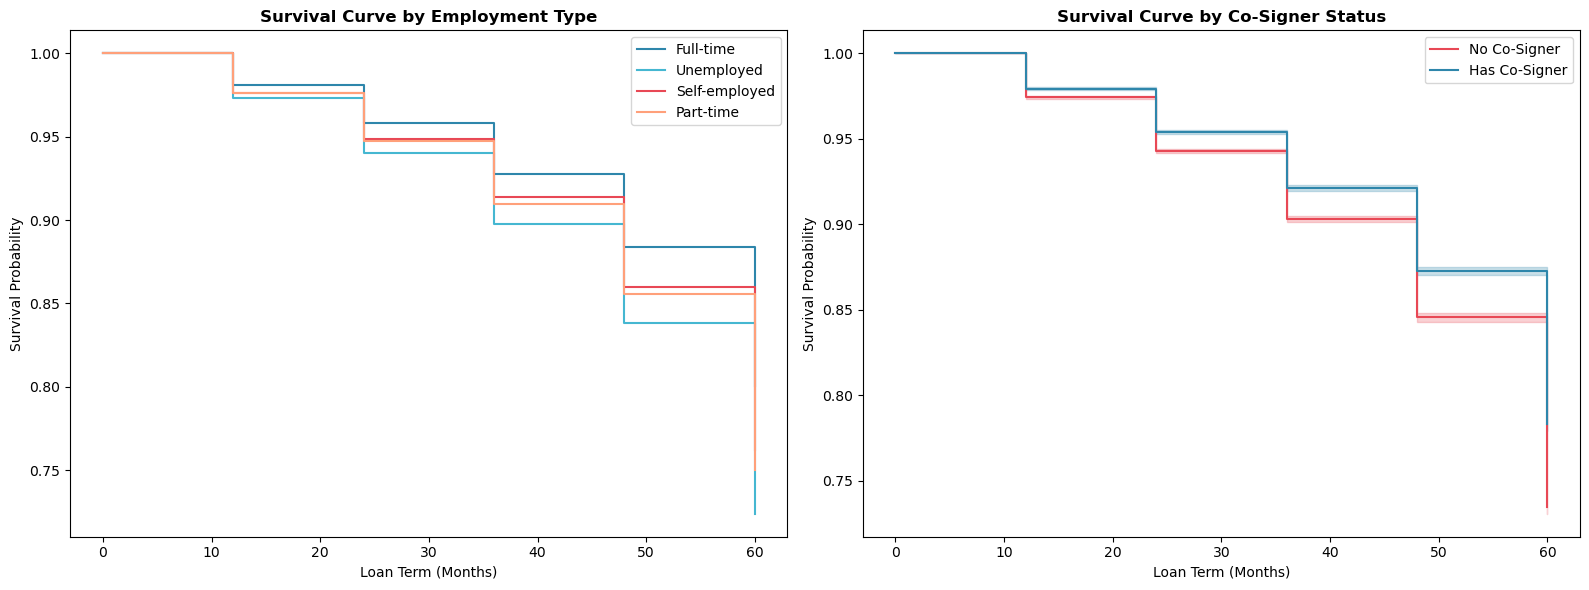

Log-Rank Test: Co-Signer vs No Co-Signer
Test Statistic: 359.6193
P-Value: 0.000000
Result: SIGNIFICANT 

Cox Proportional Hazards Model:


<lifelines.CoxPHFitter: fitted with 255347 total observations, 225694 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 255347
number of events observed = 29653
   partial log-likelihood = -340821.99
         time fit was run = 2026-02-26 04:50:05 UTC

---
              coef exp(coef)      p
covariate                          
Age          -0.03      0.97 <0.005
Income       -0.00      1.00 <0.005
LoanAmount    0.00      1.00 <0.005
CreditScore  -0.00      1.00 <0.005
InterestRate  0.06      1.06 <0.005
DTIRatio      0.22      1.24 <0.005
HasCoSigner  -0.23      0.80 <0.005
Unemployed    0.21      1.24 <0.005
---
Concordance = 0.71
Partial AIC = 681659.98
log-likelihood ratio test = 16390.32 on 8 df
-log2(p) of ll-ratio test = inf

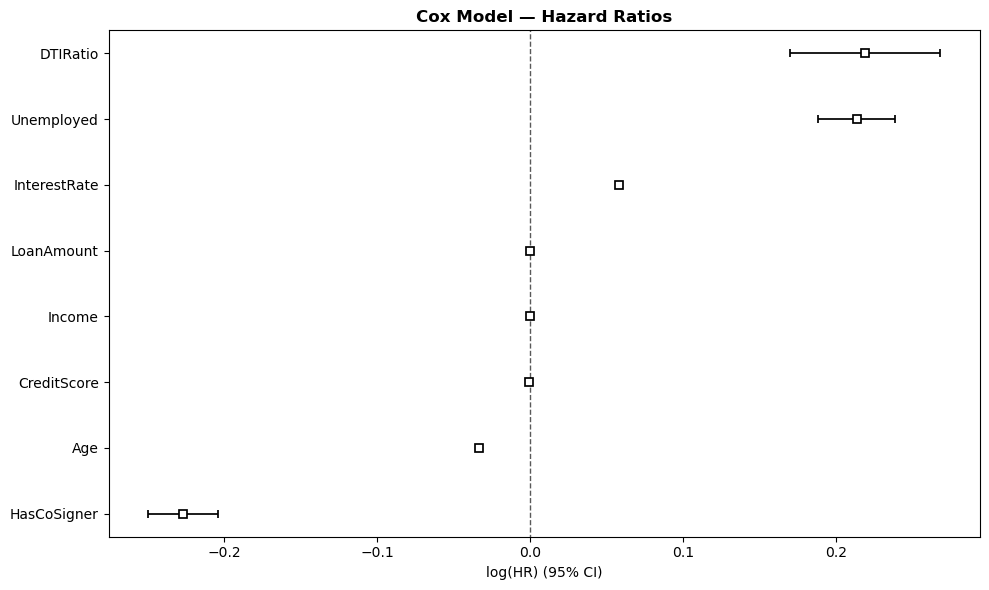

In [7]:
# ---- KM CURVES BY EMPLOYMENT TYPE ----
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: By Employment Type
kmf = KaplanMeierFitter()
colors = ['#2E86AB', '#45B7D1', '#E84855', '#FFA07A']
for i, emp_type in enumerate(df['EmploymentType'].unique()):
    mask = df['EmploymentType'] == emp_type
    kmf.fit(df[mask]['duration'], 
            event_observed=df[mask]['event'],
            label=emp_type)
    kmf.plot_survival_function(ax=axes[0], ci_show=False, color=colors[i])

axes[0].set_title('Survival Curve by Employment Type', fontweight='bold')
axes[0].set_xlabel('Loan Term (Months)')
axes[0].set_ylabel('Survival Probability')

# Plot 2: By Has CoSigner
for i, (val, label) in enumerate([('No', 'No Co-Signer'), ('Yes', 'Has Co-Signer')]):
    mask = df['HasCoSigner'] == val
    kmf.fit(df[mask]['duration'],
            event_observed=df[mask]['event'],
            label=label)
    kmf.plot_survival_function(ax=axes[1], ci_show=True,
                               color=['#E84855', '#2E86AB'][i])

axes[1].set_title('Survival Curve by Co-Signer Status', fontweight='bold')
axes[1].set_xlabel('Loan Term (Months)')
axes[1].set_ylabel('Survival Probability')

plt.tight_layout()
plt.savefig('../visuals/08_km_by_group.png', dpi=150, bbox_inches='tight')
plt.show()

# ---- LOG RANK TEST — CoSigner ----
group1 = df[df['HasCoSigner'] == 'No']
group2 = df[df['HasCoSigner'] == 'Yes']

result = logrank_test(group1['duration'], group2['duration'],
                      event_observed_A=group1['event'],
                      event_observed_B=group2['event'])

print("Log-Rank Test: Co-Signer vs No Co-Signer")
print(f"Test Statistic: {result.test_statistic:.4f}")
print(f"P-Value: {result.p_value:.6f}")
print(f"Result: {'SIGNIFICANT ' if result.p_value < 0.05 else 'NOT SIGNIFICANT '}")

# ---- COX PROPORTIONAL HAZARDS ----
# Prepare data for Cox model
df_cox = df[['duration', 'event', 'Age', 'Income', 'LoanAmount', 
             'CreditScore', 'InterestRate', 'DTIRatio']].copy()
df_cox['HasCoSigner'] = (df['HasCoSigner'] == 'Yes').astype(int)
df_cox['Unemployed'] = (df['EmploymentType'] == 'Unemployed').astype(int)

cph = CoxPHFitter()
cph.fit(df_cox, duration_col='duration', event_col='event')

print("\nCox Proportional Hazards Model:")
cph.print_summary(columns=['coef', 'exp(coef)', 'p'])
plt.figure(figsize=(10, 6))
cph.plot()
plt.title('Cox Model — Hazard Ratios', fontweight='bold')
plt.tight_layout()
plt.savefig('../visuals/09_cox_model.png', dpi=150, bbox_inches='tight')
plt.show()